# PINN for DEs

This notebook implements Physics Informed Neural Network (PINN) to solve the logistic equation 
$$
\frac{df}{dx} - R\cdot f\cdot (1-f) = 0
$$

The idea is to represent the function $f$ by a neural network $f_\theta$ specified by the parameters $\theta$ and then optimize it to minimize the square of the DE above, i.e. to reach the function where the above equation is satisfied for the given domain. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


## Defnining a general neural network class

In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = [] 
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


## Problem specific defninition of the loss function

In [3]:
R = 1.0
X_BOUNDARY=0.0
FUN_BOUNDARY=0.5
NUM_INPUTS = 1
DOMAIN = (-5, 5)

In [4]:
def loss_fun(
        model: tf.keras.Model,
        x: tf.Tensor
)->tf.Tensor:
    with tf.GradientTape() as tape: # required in order to calculate the derivatives
        tape.watch(x)
        u = model(x)
    
    u_x = tape.gradient(u, x) # df/dx

    pde = u_x - R*u*(1.0 - u) # the PDE 
    boundary = model(tf.convert_to_tensor([X_BOUNDARY])) - tf.convert_to_tensor([FUN_BOUNDARY]) # boundary condition f_\theta (X_BOUNDARY) - F(X_BOUNDARY) = 0

    interior_loss = tf.reduce_mean(tf.square(pde)) # mean square of the PDE forms the PDE loss
    boundary_loss = tf.square(boundary) # square of the boundary term forms the boundary loss

    loss = interior_loss + boundary_loss

    return loss

## Training the model!

In [5]:
NUM_LAYERS = 5
NUM_NEURONS = 5
EPOCHS = 10000 #how many times the training step is performed
BATCH_SIZE = 30 # how many input values are considered for each epoch
LEARNING_RATE = 5e-3
TOLERANCE = 5e-6

In [6]:
model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

@tf.function
def train_step(model, input): # function for one single training step
    with tf.GradientTape() as tape:
        loss = loss_fun(model, input)

    gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimize the parameters to minimize the loss

    return loss

for epoch in range(EPOCHS):
    input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=DOMAIN[0], maxval=DOMAIN[1], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
    loss = train_step(model, input_batch) # run the train step for the given batch
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss[0][0]}')
    if loss[0][0] <= TOLERANCE:
        print(f'Converged at epoch {epoch}')
        break



Epoch: 0, Loss: 0.3267291784286499
Epoch: 10, Loss: 0.06241393834352493
Epoch: 20, Loss: 0.06593126058578491
Epoch: 30, Loss: 0.04345840588212013
Epoch: 40, Loss: 0.027782799676060677
Epoch: 50, Loss: 0.022613495588302612
Epoch: 60, Loss: 0.019648978486657143
Epoch: 70, Loss: 0.009683259762823582
Epoch: 80, Loss: 0.003251955844461918
Epoch: 90, Loss: 0.0005685655050911009
Epoch: 100, Loss: 0.00028339202981442213
Epoch: 110, Loss: 0.00010509743151487783
Epoch: 120, Loss: 0.0002583304012659937
Epoch: 130, Loss: 0.0003712830657605082
Epoch: 140, Loss: 0.00021431816276162863
Epoch: 150, Loss: 0.00012960638559889048
Epoch: 160, Loss: 0.00015843652363400906
Epoch: 170, Loss: 0.00022466311929747462
Epoch: 180, Loss: 8.341222564922646e-05
Epoch: 190, Loss: 7.551797170890495e-05
Epoch: 200, Loss: 0.00012751280155498534
Epoch: 210, Loss: 0.00014878921501804143
Epoch: 220, Loss: 0.00013841579493600875
Epoch: 230, Loss: 5.0251936045242473e-05
Epoch: 240, Loss: 0.00010750299406936392
Epoch: 250, Lo

## Prediction and Plotting!

In [7]:
def analytical_sol_fn(
        x: tf.Tensor
)-> tf.Tensor:
    return 1.0 / (1.0 + (1.0/FUN_BOUNDARY - 1.0) * tf.exp(-R * x))

x_plot = tf.linspace(DOMAIN[0], DOMAIN[1], 1000)[:, tf.newaxis]
y_pred = model(x_plot)
y_anlt = analytical_sol_fn(x_plot)

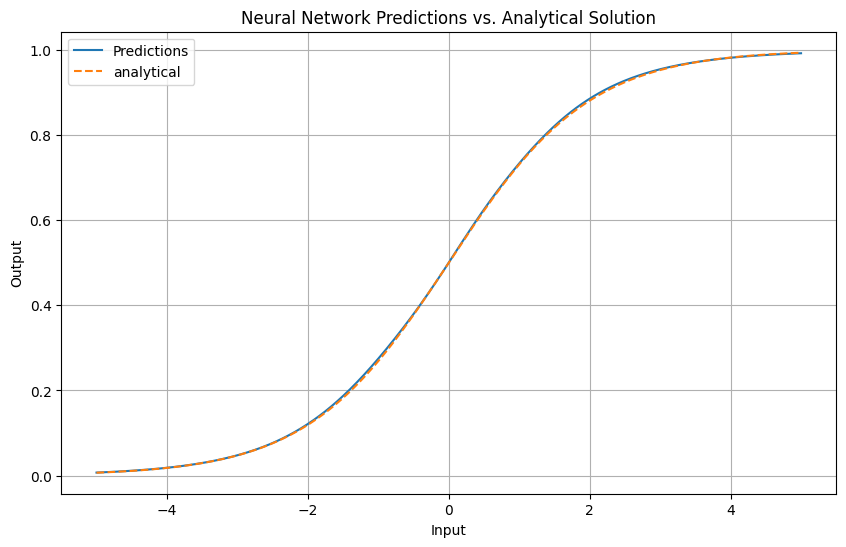

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_pred, label='Predictions')
plt.plot(x_plot, y_anlt, label='analytical', linestyle='dashed')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Neural Network Predictions vs. Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()